In [ ]:
! pip install neptune-client
! pip install torchmetrics
! pip install fvcore simplejson timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 8.0 MB/s 
     |████████████████████████████████| 829 kB 62.2 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 181 kB 73.9 MB/s 
     |████████████████████████████████| 132 kB 74.8 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 9.1 MB 56.9 MB/s 
     |████████████████████████████████| 140 kB 71.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 127 kB 68.5 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 130 kB 72.5 MB/s 
     |████████████████████████████████| 82 kB 801 kB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 81 kB



1.   Go to https://drive.google.com/drive/folders/1j5jrtQ2zIuSRyIPni2tVmyU1SEB-VORz?usp=sharing
2.   Make a copy of major.zip
3.   Move the copy to your own drive
4.   Rename the copy back to major.zip
5.   Change the `unzip` path from `/content/drive/MyDrive/VIP/major.zip` to the saved location.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/VIP/major.zip

Streaming output truncated to the last 5000 lines.
  inflating: Major/data/Taming_class_423_000929.png  
  inflating: Major/data/gated_inpainting_id000000065855.png  
  inflating: Major/data/stylegan3_ffhq-r_seed0954.png  
  inflating: Major/data/000000035498.jpg  
  inflating: Major/data/glide_text2img_annot000000138934.png  
  inflating: Major/data/gated_inpainting_id000000018476.png  
  inflating: Major/data/Taming_ffhq_036014.png  
  inflating: Major/data/realffhq_25162.png  
  inflating: Major/data/000000060641.jpg  
  inflating: Major/data/glide_text2img_annot000000088143.png  
  inflating: Major/data/Taming_coco_samples_4865_samples_nopix_003298.png  
  inflating: Major/data/gated_inpainting_id000000067634.png  
  inflating: Major/data/glide_text2img_annot000000031458.png  
  inflating: Major/data/stylegan2_horse_stylegan2-config-f-psi-10_042597.png  
  inflating: Major/data/000000437145.jpg  
  inflating: Major/data/000000296848.jpg  
  inflating: Major/data/stylegan3_afhq-r_se

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt 

import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import RandomCrop

In [ ]:
with open("Major/train.txt","r+") as f0:
  train_list = f0.read().split("\n")

with open("Major/val.txt","r+") as f0:
  val_list = f0.read().split("\n")

with open("Major/test.txt","r+") as f0:
  test_list = f0.read().split("\n")

labels = pd.read_csv("Major/labels.csv")

In [ ]:
def construct_dataloder(dataset, batch_size, shuffle=True, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers)

class VIPDataset(Dataset):
    def __init__(self, file_ids, labels, data_dir,):
        self.file_ids = file_ids
        self.labels = labels
        self.data_dir = data_dir
        self.aug = transform = A.Compose([
            A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_LINEAR,p=0.3),
            A.augmentations.transforms.ImageCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.3),
            # A.augmentations.crops.transforms.RandomCrop(width=200, height=200,p=1)
        ])
        self.trans = A.Compose([RandomCrop(width=160, height=160,p=1), ToTensorV2()])

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        x = np.array(Image.open(os.path.join(self.data_dir, image_id)))
        x = self.aug(image=x)['image']
        x = self.trans(image=x)['image']
        y = int(self.labels.loc[self.labels["image_ids"] == image_id,"label"])
        return x, torch.nn.functional.one_hot(torch.from_numpy(np.array(y)), 2)

    def augment(self, x):
        """Augmentations for images"""
        return self.aug_pipeline(image=x)["image"]

In [ ]:
train_ds = VIPDataset(train_list,labels,"Major/data")
val_ds = VIPDataset(val_list,labels,"Major/data")
test_ds = VIPDataset(test_list,labels,"Major/data")

In [ ]:
train_dl = construct_dataloder(train_ds, 8, shuffle=True, num_workers=2)
val_dl = construct_dataloder(val_ds, 8, shuffle=True, num_workers=2)
test_dl = construct_dataloder(test_ds, 8, shuffle=True, num_workers=2)

8332 torch.Size([3, 160, 160]) torch.Size([2])
tensor([1, 0])
11562 torch.Size([3, 160, 160]) torch.Size([2])
tensor([0, 1])
12404 torch.Size([3, 160, 160]) torch.Size([2])
tensor([1, 0])
3142 torch.Size([3, 160, 160]) torch.Size([2])
tensor([0, 1])


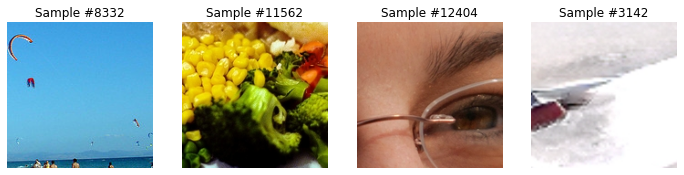

In [ ]:
plt.figure(figsize=(12,4))
for j, i in enumerate(random.sample(set(range(len(train_ds))), 4)):
    sample_image, sample_label = train_ds[i]
    print(i, sample_image.shape, sample_label.shape)

    ax = plt.subplot(1, 4, j + 1)
#     plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.transpose(sample_image, (1, 2, 0)))
    print(sample_label)
    if i == 3:
        plt.show()
        break

In [ ]:
! git clone https://github.com/wangjk666/M2TR-Multi-modal-Multi-scale-Transformers-for-Deepfake-Detection.git
! cp -r /content/M2TR-Multi-modal-Multi-scale-Transformers-for-Deepfake-Detection/* .

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchmetrics import Recall, Precision, F1Score, Accuracy
metrics = {
    'accuracy': Accuracy(num_classes=2, average='macro').to(device),
    'recall': Recall(num_classes=2, average='macro').to(device),
    'precision': Precision(num_classes=2, average='macro').to(device),
    'f1_score': F1Score(num_classes=2, average='macro').to(device)
}

In [ ]:
import neptune.new as neptune
run = neptune.init(
    project="Botz/VIPCup-logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)

https://app.neptune.ai/Botz/VIPCup-logs/e/VIP-48
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
import yaml

with open('/content/drive/MyDrive/VIP/M2TR/configs/colab.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

In [ ]:
params = {
    "Model-Name": cfg['MODEL']['MODEL_NAME'],
    'Dataset-Name': cfg['DATASET']['DATASET_NAME'],
    "max_epochs": cfg['TRAIN']['MAX_EPOCH'],
}
run["parameters"] = params

In [ ]:
import pprint

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

import M2TR.utils.checkpoint as cu
import M2TR.utils.distributed as du
import M2TR.utils.logging as logging
from M2TR.utils.build_helper import (
    build_dataloader,
    build_dataset,
    build_loss_fun,
    build_model,
)
from M2TR.utils.meters import EpochTimer, MetricLogger, SmoothedValue
from M2TR.utils.optimizer import build_optimizer
from M2TR.utils.scheduler import build_scheduler
from tools.test import perform_test

import tqdm.notebook as tq

logger = logging.get_logger(__name__)


@torch.no_grad()
def perform_test(
    test_loader, model, cfg, cur_epoch=None, writer=None, mode='Test'
):
    criterion = build_loss_fun(cfg)

    record_list = list(metrics.keys())
    recorder = {metric: [] for metric in record_list}

    model.eval()

    for imgs, labels in tq.tqdm(test_loader):
        imgs = imgs.to(device).float()
        labels = labels.to(device).float()
        
        samples = {'img': imgs, 'bin_label_onehot': labels}

        with torch.cuda.amp.autocast(enabled=cfg['AMP_ENABLE']):
            outputs = model(samples)
            loss = criterion(outputs, samples)

        
        for i in record_list:
            preds = torch.argmax(outputs['logits'], dim=1)
            labels = torch.argmax(samples['bin_label_onehot'], dim=1)
            recorder[i].append(metrics[i](preds, labels))

    for i in record_list:
        metric = sum(recorder[i])/len(recorder[i])
        recorder[i] = metric
        run[f'train/{i}'].log(metric)
    
    return recorder


def train_epoch(
    train_loader, model, criterion, optimizer, cfg, cur_epoch, cur_iter, writer, prev_acc
):
    model.train()
    header = 'Epoch: [{}]'.format(cur_epoch)
    print_freq = 10

    record_list = list(metrics.keys())
    recorder = {metric: [] for metric in record_list}

    for imgs, labels in tq.tqdm(train_loader):
        imgs = imgs.to(device).float()
        labels = labels.to(device).float()
        
        samples = {'img': imgs, 'bin_label_onehot': labels}

        with torch.cuda.amp.autocast(enabled=cfg['AMP_ENABLE']):
            outputs = model(samples)
            loss = criterion(outputs, samples)

        
        for i in record_list:
            preds = torch.argmax(outputs['logits'], dim=1)
            labels = torch.argmax(samples['bin_label_onehot'], dim=1)
            recorder[i].append(metrics[i](preds, labels))

        loss_value = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()

        if 'CLIP_GRAD_L2NORM' in cfg['TRAIN']:  # TODO
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), cfg['TRAIN']['CLIP_GRAD_L2NORM']
            )

        if writer:
            writer.add_scalar('train loss', loss_value, global_step=cur_iter)
            writer.add_scalar(
                'lr', optimizer.param_groups[0]["lr"], global_step=cur_iter
            )
        cur_iter = cur_iter + 1

    for i in record_list:
        metric = sum(recorder[i])/len(recorder[i])
        run[f'train/{i}'].log(metric)

    return {}, cur_iter


def train(
    train_loader, val_loader, cfg
):
    np.random.seed(cfg['RNG_SEED'])
    torch.manual_seed(cfg['RNG_SEED'])

    logging.setup_logging(cfg)
    logger.propagate = False
    logger.info(pprint.pformat(cfg))
    if du.is_master_proc(du.get_world_size()):
        writer = SummaryWriter(cfg['LOG_FILE_PATH'])
    else:
        writer = None

    best_model = model = build_model(cfg)
    optimizer = build_optimizer(model.parameters(), cfg)
    scheduler, _ = build_scheduler(optimizer, cfg)  # TODO _?
    loss_fun = build_loss_fun(cfg)

    start_epoch = cu.load_train_checkpoint(model, optimizer, scheduler, cfg)

    logger.info("Start epoch: {}".format(start_epoch + 1))
    epoch_timer = EpochTimer()

    cur_iter = 0
    best_acc = 0

    for cur_epoch in range(start_epoch, cfg['TRAIN']['MAX_EPOCH']):
        print('========================================================')
        epoch_timer.epoch_tic()
        _, cur_iter = train_epoch(
            train_loader,
            model,
            loss_fun,
            optimizer,
            cfg,
            cur_epoch,
            cur_iter,
            writer,
        )
        epoch_timer.epoch_toc()
        recorder = perform_test(val_loader, model, cfg, cur_epoch, writer, mode='Val')
        
        if recorder['accuracy'] > best_acc:
            best_acc = recorder['accuracy']
            best_model = model
        
        print(
            f"Epoch {cur_epoch} takes {epoch_timer.last_epoch_time():.2f}s. Epochs "
            f"from {start_epoch} to {cur_epoch} take "
            f"{epoch_timer.avg_epoch_time():.2f}s in average and "
            f"{epoch_timer.median_epoch_time():.2f}s in median."
        )
        print(
            f"For epoch {cur_epoch}, each iteraction takes "
            f"{epoch_timer.last_epoch_time()/len(train_loader):.2f}s in average. "
            f"From epoch {start_epoch} to {cur_epoch}, each iteraction takes "
            f"{epoch_timer.avg_epoch_time()/len(train_loader):.2f}s in average."
        )

        scheduler.step(cur_epoch)

        is_checkp_epoch = cu.is_checkpoint_epoch(cfg, cur_epoch)

        if is_checkp_epoch:
            cu.save_checkpoint(model, optimizer, scheduler, cur_epoch, cfg)

    if writer:
        writer.flush()
        writer.close()
    
    return best_model

In [ ]:
model_ft = train(
    train_dl,
    val_dl,
    cfg=cfg,
)

[08/26 15:35:54][INFO] build_helper.py:  22: MODEL_NAME: M2TR
Loaded pretrained weights for efficientnet-b4
[08/26 15:35:55][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/1956 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


accuracy: 0.6328616142272949
recall: 0.6328616142272949
precision: 0.6304103136062622
f1_score: 0.6029554605484009
[08/26 15:44:46][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/452 [00:00<?, ?it/s]

accuracy: 0.701360285282135
recall: 0.701360285282135
precision: 0.6985962390899658
f1_score: 0.6696589589118958
Epoch 0 takes 530.62s. Epochs from 0 to 0 take 530.62s in average and 530.62s in median.
For epoch 0, each iteraction takes 0.27s in average. From epoch 0 to 0, each iteraction takes 0.27s in average.


  0%|          | 0/1956 [00:00<?, ?it/s]

accuracy: 0.6984176635742188
recall: 0.6984176635742188
precision: 0.6918060779571533
f1_score: 0.662611186504364
[08/26 15:55:13][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/452 [00:00<?, ?it/s]

accuracy: 0.7280706763267517
recall: 0.7280706763267517
precision: 0.7286988496780396
f1_score: 0.6976879239082336
Epoch 1 takes 534.68s. Epochs from 0 to 1 take 532.65s in average and 532.65s in median.
For epoch 1, each iteraction takes 0.27s in average. From epoch 0 to 1, each iteraction takes 0.27s in average.


  0%|          | 0/1956 [00:00<?, ?it/s]

accuracy: 0.7169869542121887
recall: 0.7169869542121887
precision: 0.7075276374816895
f1_score: 0.6816532015800476
[08/26 16:05:33][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/452 [00:00<?, ?it/s]

accuracy: 0.7399230599403381
recall: 0.7399230599403381
precision: 0.7432518601417542
f1_score: 0.710514485836029
Epoch 2 takes 527.36s. Epochs from 0 to 2 take 530.89s in average and 530.62s in median.
For epoch 2, each iteraction takes 0.27s in average. From epoch 0 to 2, each iteraction takes 0.27s in average.


  0%|          | 0/1956 [00:00<?, ?it/s]

accuracy: 0.7291555404663086
recall: 0.7291555404663086
precision: 0.7214447855949402
f1_score: 0.6937553286552429
[08/26 16:15:55][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/452 [00:00<?, ?it/s]

accuracy: 0.7446717023849487
recall: 0.7446717023849487
precision: 0.7498773336410522
f1_score: 0.7185534834861755
Epoch 3 takes 526.51s. Epochs from 0 to 3 take 529.79s in average and 528.99s in median.
For epoch 3, each iteraction takes 0.27s in average. From epoch 0 to 3, each iteraction takes 0.27s in average.


  0%|          | 0/1956 [00:00<?, ?it/s]

accuracy: 0.7335599064826965
recall: 0.7335599064826965
precision: 0.7236390709877014
f1_score: 0.6970288753509521
[08/26 16:26:09][INFO] build_helper.py:  50: LOSS_FUN: FocalLoss


  0%|          | 0/452 [00:00<?, ?it/s]

accuracy: 0.7360773086547852
recall: 0.7360773086547852
precision: 0.7387229204177856
f1_score: 0.70933598279953
Epoch 4 takes 519.96s. Epochs from 0 to 4 take 527.83s in average and 527.36s in median.
For epoch 4, each iteraction takes 0.27s in average. From epoch 0 to 4, each iteraction takes 0.27s in average.


In [ ]:
# Change model save path to the preferred save location
import time
model_name = f"/content/drive/MyDrive/VIP/model_{int(time.time())}.pt"
torch.save(model_ft, model_name)
print(model_name)

/content/drive/MyDrive/VIP/model_1661531618.pt


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Botz/VIPCup-logs/e/VIP-48


# Test

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm

In [ ]:
def construct_dataloder(dataset, batch_size, shuffle=True, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers)

class VIPDataset(Dataset):
    def __init__(self, file_ids, labels, data_dir,):
        self.file_ids = file_ids
        self.labels = labels
        self.data_dir = data_dir
        self.aug = transform = A.Compose([
            A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_LINEAR,p=0.3),
            A.augmentations.transforms.ImageCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.3),
            # A.augmentations.crops.transforms.RandomCrop(width=200, height=200,p=1)
        ])
        self.trans = A.Compose([RandomCrop(width=160, height=160,p=1), ToTensorV2()])

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        x = np.array(Image.open(os.path.join(self.data_dir, image_id)))
        x = self.aug(image=x)['image']
        x = self.trans(image=x)['image']
        y = int(self.labels.loc[self.labels["image_ids"] == image_id,"label"])
        return x, torch.nn.functional.one_hot(torch.from_numpy(np.array(y)), 2), image_id

    def augment(self, x):
        """Augmentations for images"""
        return self.aug_pipeline(image=x)["image"]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/VIP/model_1661531618.pt').to(device)

In [ ]:
use_softmax = False
accuracies = []
result_pd = pd.DataFrame([], columns=['filename', 'logit', 'label'])
for imgs, labels, filenames in tqdm(test_dl):
  imgs = imgs.to(device).float()
  labels = labels.to(device).float()
  outputs = model({'img': imgs, 'bin_label_onehot': labels})
  preds = torch.argmax(outputs['logits'], dim=1)
  labels = torch.argmax(labels, dim=1)
  new_pd = pd.DataFrame({'filename': filenames, 'logit': preds.cpu(), 'label': labels.cpu()})
  result_pd = pd.concat([result_pd, new_pd])
  
  accuracy = metrics['accuracy'](preds, labels.to(device))
  accuracies.append(accuracy)

print(f"Accuracy: {sum(accuracies)/len(accuracies)}")


100%|██████████| 603/603 [02:01<00:00,  4.98it/s]

Accuracy: 0.7333747744560242


In [ ]:
result_pd.head()

,filename,logit,label
0,gated_inpainting_id000000262985.png,1,1
1,000000213740.jpg,0,0
2,gated_inpainting_id000000401569.png,0,1
3,realffhq_66995.png,0,0
4,000000459166.jpg,0,0


In [ ]:
result_pd.label = result_pd.label.astype(int)

In [ ]:
result_pd.to_csv('result.csv', index=False)

In [ ]:
correct = result_pd.logit == result_pd.label

In [ ]:
correct

0     True
1     True
2    False
3     True
4     True
     ...  
5     True
6    False
7     True
0    False
1     True
Length: 4818, dtype: bool

In [ ]:
sum(correct) / len(correct)

0.7345371523453715